# Práctica individual

## Alumno: Cesar Adrian Cuesta Sanchez


### Clustering, técnicas de agrupamiento

**Objetivo**: 

Aplicar e interpretar los resultados de un algoritmo de Clustering aplicado sobre el
conjunto de datos. Se recomienda la aplicación del **algoritmo K-MEANS.**


In [27]:
#importaciones de librerias necesarias:

import pandas as pd
import numpy as np 
from sklearn import metrics

#### 1. Carga de los datos

Vamos a cargar el dataset para empezar nuestro analisis de los datos:

In [26]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
data = pd.read_csv(url)
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


**Eliminación de atributos innecesarios**

Ya que vamos a realizar un ejercicio de Clustering no supervisado no necesitamos los atributos: 'Channel' y 'Region' por lo tanto podemos eliminarlos del dataframe: predicción


In [10]:
y = data['Channel'].copy()
data.drop(['Channel','Region'], axis=1,inplace = True) #borramos las columnas: 'Channel','Region'

In [11]:
stats = data.describe()
stats

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Según la documentación en el set de datos tenemos valores faltantes pero vamos a comprobarlo:

>Vemos que efectivamente cada uno de los valores esta completo con 440 registros

### Analisis de outliers

>Ya que en algoritmo implica la medicion de distancias a los centroides, los outliers pueden
afectar los resultados esperados. 

>Primero veamos la correlacion existente entre los datos:


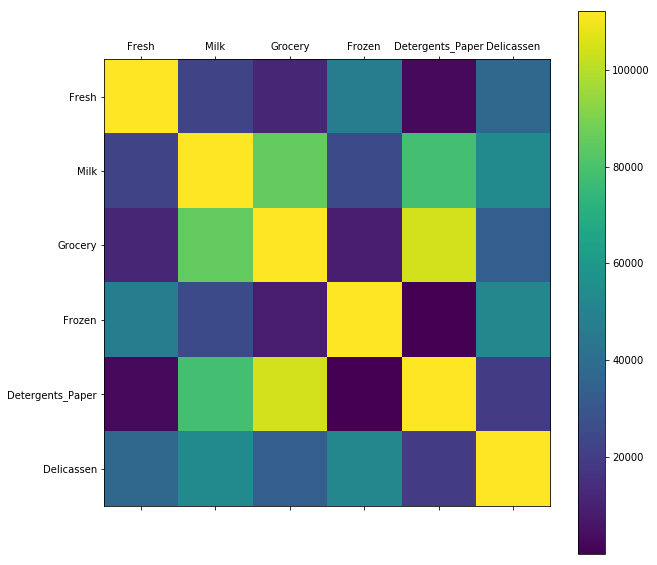

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_corr(df,size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(df, interpolation='nearest')
    ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

plot_corr(data)

Del grafico anterior podemos ver que existen interrelacion entre:
>'Detergents_Paper' y 'Grocery',
>'Milk' y 'Grocery',
>'Detergents_Paper' y 'Milk'

Teniendo en cuenta los percentiles anteriores vamos a sacar 3 ejemplos para realizar la comprobación 
de nuestros cálculos despues de la implementación de Kmeans en cada uno de los cuartiles:

- 43: Muy bajo "Fresh" y muy alto "Grocery"
- 12: Muy bajo "Frozen" y muy alto "Fresh"
- 39: Muy alto "Frozen" y Muy bajo "Detergens_Paper"

In [13]:
indices = [43, 12, 39]

samples = pd.DataFrame(data.loc[indices], columns = data.columns).reset_index(drop = True)
print ("algunos ejemplos elegidos de nuestro dataset:")
display(samples)

algunos ejemplos elegidos de nuestro dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,630,11095,23998,787,9529,72
1,31714,12319,11757,287,3881,2931
2,56159,555,902,10002,212,2916


Para la deteccion y eliminacion de ourliers vamos a utilizar el metodo **Tukey’s Metodo**, el cual consiste
basicamente en la deteccion de valores maximos y minimos, en el 1er y 3er cuartil: 

Para lo cual solo vamos a eliminar los outliers que aparecen en mas de una caracteristica esto con el fin 
de no perder demasiada informacion.

In [15]:
outliers  = []

# Calculo de los outliers por cada caracteristica
for feature in data.keys():
    
    # TODO: Calculo Q1 (25th percentil de los datos) para una caracteristicas dadas
    Q1 = np.percentile(data[feature],25)
    
    # TODO: Calculo Q3 (75th percentil de los datos) para una caracteristicas dadas
    Q3 = np.percentile(data[feature],75)
    
    # TODO: Uso del rango interquartil para calcular outlier step (1.5)
    step = (Q3-Q1) * 1.5
    
    # Mostrar los ourliers
    print ("valores considerados outliers para la caracteristica: '{}':".format(feature))
    out = data[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))]
    display(out)
    outliers = outliers + list(out.index.values)
    

#Creando una lista de outliers por caracetristica
outliers = list(set([x for x in outliers if outliers.count(x) > 1]))    

print ("Indice de los Outliers: {}".format(outliers), 'Total:', len(outliers))

# remove los outliers, que se repiten en las caracteristicas
good_data = data.drop(data.index[outliers]).reset_index(drop = True)
y = y.drop(y.index[outliers]).reset_index(drop = True)
print ("En good_data ahora tiene {} observaciones despues de remover los outliers.".format(len(good_data)))

valores considerados outliers para la caracteristica: 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
29,43088,2100,2609,1200,1107,823
39,56159,555,902,10002,212,2916
47,44466,54259,55571,7782,24171,6465
52,40721,3916,5876,532,2587,1278
87,43265,5025,8117,6312,1579,14351
103,56082,3504,8906,18028,1480,2498
125,76237,3473,7102,16538,778,918
129,42312,926,1510,1718,410,1819
176,45640,6958,6536,7368,1532,230
181,112151,29627,18148,16745,4948,8550


valores considerados outliers para la caracteristica: 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
23,26373,36423,22019,5154,4337,16523
28,4113,20484,25957,1158,8604,5206
38,4591,15729,16709,33,6956,433
45,5181,22044,21531,1740,7353,4985
47,44466,54259,55571,7782,24171,6465
49,4967,21412,28921,1798,13583,1163
56,4098,29892,26866,2616,17740,1340
61,35942,38369,59598,3254,26701,2017
65,85,20959,45828,36,24231,1423
85,16117,46197,92780,1026,40827,2944


valores considerados outliers para la caracteristica: 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
28,4113,20484,25957,1158,8604,5206
43,630,11095,23998,787,9529,72
47,44466,54259,55571,7782,24171,6465
49,4967,21412,28921,1798,13583,1163
56,4098,29892,26866,2616,17740,1340
61,35942,38369,59598,3254,26701,2017
65,85,20959,45828,36,24231,1423
77,12205,12697,28540,869,12034,1009
85,16117,46197,92780,1026,40827,2944
86,22925,73498,32114,987,20070,903


valores considerados outliers para la caracteristica: 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
22,31276,1917,4469,9408,2381,4334
39,56159,555,902,10002,212,2916
40,24025,4332,4757,9510,1145,5864
47,44466,54259,55571,7782,24171,6465
70,16705,2037,3202,10643,116,1365
72,4420,5139,2661,8872,1321,181
73,19899,5332,8713,8132,764,648
88,7864,542,4042,9735,165,46
91,12754,2762,2530,8693,627,1117
93,11314,3090,2062,35009,71,2698


valores considerados outliers para la caracteristica: 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
43,630,11095,23998,787,9529,72
47,44466,54259,55571,7782,24171,6465
49,4967,21412,28921,1798,13583,1163
56,4098,29892,26866,2616,17740,1340
61,35942,38369,59598,3254,26701,2017
65,85,20959,45828,36,24231,1423
77,12205,12697,28540,869,12034,1009
85,16117,46197,92780,1026,40827,2944
86,22925,73498,32114,987,20070,903
92,9198,27472,32034,3232,18906,5130


valores considerados outliers para la caracteristica: 'Delicassen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
2,6353,8808,7684,2405,3516,7844
4,22615,5410,7198,3915,1777,5185
17,5876,6157,2933,839,370,4478
22,31276,1917,4469,9408,2381,4334
23,26373,36423,22019,5154,4337,16523
24,22647,9776,13792,2915,4482,5778
28,4113,20484,25957,1158,8604,5206
36,29955,4362,5428,1729,862,4626
40,24025,4332,4757,9510,1145,5864
45,5181,22044,21531,1740,7353,4985


Indice de los Outliers: [384, 265, 145, 22, 23, 28, 284, 163, 39, 40, 171, 427, 45, 43, 47, 304, 49, 181, 437, 183, 56, 61, 319, 65, 325, 201, 331, 77, 333, 211, 85, 86, 87, 216, 343, 92, 358, 103, 109, 251, 125] Total: 41
En good_data ahora tiene 399 observaciones despues de remover los outliers.


Vamos a realizar nuestra implementación de KMeans donde haremos la prueba con 9 valores cluster diderentes:

In [16]:
# Importaciones necesarias: 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Creamos un rango de clusteres para realizar pruebas
range_n_clusters = list(range(2,11))
print(range_n_clusters)

[2, 3, 4, 5, 6, 7, 8, 9, 10]


In [23]:
# for para cada uno de los clusteres
for n_clusters in range_n_clusters:
    # TODO: Aplicar el algoritmo con cada cluster
    clusterer = KMeans(n_clusters=n_clusters).fit(good_data)
    #Prediccion
    preds = clusterer.predict(good_data)
    #Encontrar los centros
    centers = clusterer.cluster_centers_
    # Prediccion con los ejemplos extraidos
    sample_preds = clusterer.predict(samples)  
    labels = clusterer.labels_
    #print(labels)
    # TODO: Calculate del silhouette coefficient para cada cluster
    score = silhouette_score(good_data, preds)
    print ("por n_clusters = {}. El promedio de silhouette_score es : {}".format(n_clusters, score))


por n_clusters = 2. El promedio de silhouette_score es : 0.4193505674736687
por n_clusters = 3. El promedio de silhouette_score es : 0.37495492685794823
por n_clusters = 4. El promedio de silhouette_score es : 0.3674080442223389
por n_clusters = 5. El promedio de silhouette_score es : 0.3402427373212877
por n_clusters = 6. El promedio de silhouette_score es : 0.3067340461046537
por n_clusters = 7. El promedio de silhouette_score es : 0.31150924494610976
por n_clusters = 8. El promedio de silhouette_score es : 0.2767365034549528
por n_clusters = 9. El promedio de silhouette_score es : 0.28368257681750164
por n_clusters = 10. El promedio de silhouette_score es : 0.2831930226959319


Vemos que el mayor valor de silhouette_score es : 0.4193505674736687 que corresponde a un valor de k = 2, teniendo en cuenta que este score va de valores de 0 a 1 siendo 0 la peor calificación y 1 la máxima posible. 

Ya que sabemos que el numero de clusteres k optimo es 2 hagamos nuestra implementación con en valor de 2: 


In [24]:
km = KMeans(n_clusters=2).fit(good_data)

#Prediccion
preds = km.predict(good_data)
#Encontrar los centros
centros = km.cluster_centers_
# Prediccion con los ejemplos extraidos
sample_pred = km.predict(samples)

In [19]:
#miremos los centros de cada una de nuestras clases:

segments = ['Cluster {}'.format(i) for i in range(0,len(centros))]
true_centers = pd.DataFrame(np.round(centros), columns = good_data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster 0,5909.0,4516.0,6465.0,2317.0,2417.0,1065.0
Cluster 1,24714.0,3739.0,5091.0,3647.0,1085.0,1595.0


**Analisis de las clases de nuestro modelo kmeans:**

Ya con los centros de las clases determinados con sus valores medios podemos hacer las siguientes
suposiciones: 

**Clase 0:** Para consumos bajos en productos 'Delicassen' y altos en 'Grocery' y 'Leche' esto puede corresponder mas a los habitos de clientes al por menor.

**Clase 1:** Para consumos de 'Fresh' altos, y bajos consumos en 'Detergents_Paper' lo cual puede 
corresponder a Restaurantes, o sitios donde se necesite compras mayores de productos frescos y pero consumos bajos en 	Detergents_Paper y menores en Milk.



### Grafico

Para realizar el grafico, de nuestro modelo vamos a reducir nuestros datos a solo dos dimensiones, para ello utilizaremos la librería decomposition de sklearn.

Luego vamos a generar nuevamente nuestro modelo, con dichas dos dimensiones y generaremos el grafico, donde los **centroides** son marcados con un numero, y los **datos de la dimension** con un color y los **ejemplos** elegido con una X 

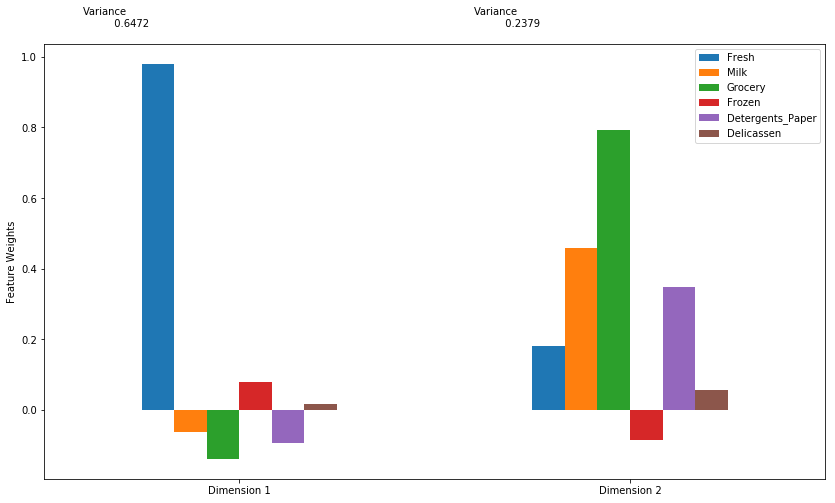

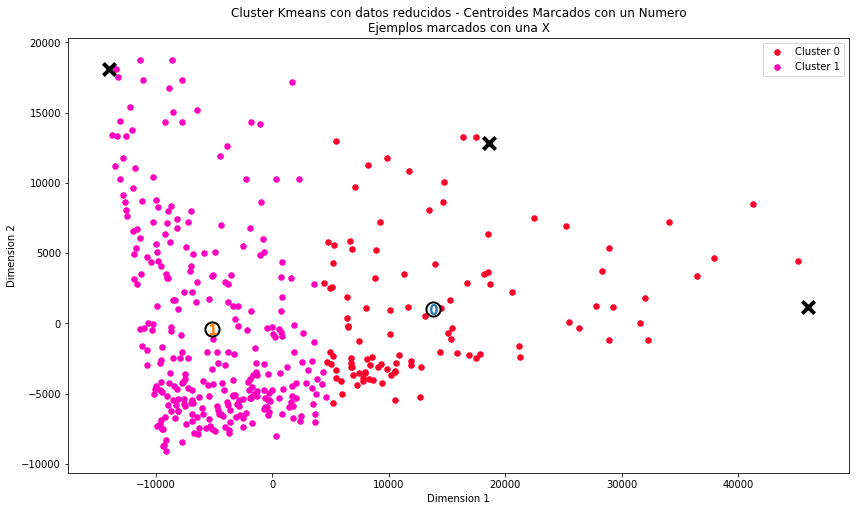

In [22]:
import visu as vs
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(good_data)
reduced_data = pca.transform(good_data)
pca_samples = pca.transform(samples)
pca_results = vs.pca_results(good_data, pca)
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
kmr = KMeans(n_clusters=2).fit(reduced_data)
preds = kmr.predict(reduced_data)
centers = kmr.cluster_centers_
sample_preds = kmr.predict(pca_samples)
score = silhouette_score(reduced_data,preds)
vs.cluster_results(reduced_data, preds, centers, pca_samples)

**Bibliografia:**
 
- https://www.ritchieng.com/machine-learning-project-customer-segments/
- https://sajalsharma.com/portfolio/customer_segments